In [91]:
# util
import pandas as pd
import numpy as np
import re
import string
import pickle

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import word_tokenize
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.pipeline import Pipeline
from collections import Counter

# sklearn
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Load Data

In [92]:
%%time

df = pd.read_csv('Labeling_NLP - FIX_Clean sampe kinclong.csv', encoding='utf-8-sig')

Wall time: 78.7 ms


In [93]:
df.head()

,teks_berita,labeling
0,Sebuah video viral di media sosial yang memper...,negatif
1,Presiden Joko Widodo hadir dalam acara Gerakan...,positif
2,Jaringan Advokat Tambang (JATAM) mendorong Ka...,negatif
3,ASEAN Tourism Festival (ATF) akan digelar pada...,positif
4,Football vs Soccer menjadi ramai diperbincangk...,positif


In [94]:
df.count()

teks_berita    1268
labeling       1005
dtype: int64

In [95]:
df = df.dropna()

In [96]:
#remove row labelled 0
df = df.loc[~(df['labeling'] == '0')]
counter = Counter(df['labeling'])
print(counter)

Counter({'positif': 743, 'negatif': 261})


# Data Prep

In [97]:
df = df.replace('negatif', 'n')
df = df.replace('positif', 'p')
df = df.replace('n', 'NEGATIF')
df = df.replace('p', 'POSITIF')

Text(0.5, 1.0, 'Distribution of data')

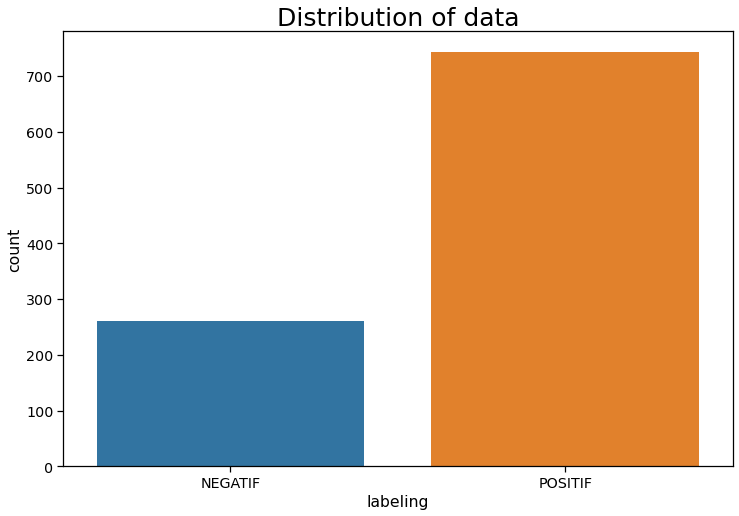

In [98]:
plt.figure(figsize=(12,8))
sns.countplot(x="labeling", data=df)
plt.title("Distribution of data", fontsize=25)

In [99]:
#Cleaning (again)
list_stopwords = stopwords.words('indonesian')
x = 'teks_berita'
df[x] = df[x].apply(lambda x: ' '.join(word.lower() for word in x.split() if word not in list_stopwords))
df[x] = df[x].str.replace('[.,!/?()\'":;\-&’`]+','')
df[x] = df[x].apply(lambda x: re.sub(r'KOMPAS\/[A-Z ]+\b', '', str(x)))
df[x] = df[x].apply(lambda x: re.sub(r' Simak berita selengkapnya .*', '', str(x)))
df[x] = df[x].apply(lambda x: re.sub(r' Simak selengkapnya .*', '', str(x)))

# stemming with Sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()
def stemming(text):
    output = stemmer.stem(text)
    return output
df["teks_berita"] = df["teks_berita"].apply(stemming)


In [100]:
df.head()

,teks_berita,labeling
0,buah video viral media sosial ajar lari panjat...,NEGATIF
1,presiden joko widodo hadir acara gera nusantar...,POSITIF
2,jaring advokat tambang jatam dorong kapolri je...,NEGATIF
3,asean tourism festival atf gelar 2 5 februari ...,POSITIF
4,football vs soccer ramai bincang media sosial ...,POSITIF


In [101]:
counter = Counter(df['labeling'])
print(counter)

Counter({'POSITIF': 743, 'NEGATIF': 261})


## POSITIVE

In [102]:
# plt.figure(figsize = (20,20)) 
# wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.labeling == 'POSITIF'].teks_berita))
# plt.imshow(wc , interpolation = 'bilinear')

## NEGATIVE

In [103]:
# plt.figure(figsize = (20,20)) 
# wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.labeling == 'NEGATIF'].teks_berita))
# plt.imshow(wc , interpolation = 'bilinear')

# Modelling

In [127]:
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek

x = df['teks_berita']
y = df['labeling']
x.shape
x.head()

0    buah video viral media sosial ajar lari panjat...
1    presiden joko widodo hadir acara gera nusantar...
2    jaring advokat tambang jatam dorong kapolri je...
3    asean tourism festival atf gelar 2 5 februari ...
4    football vs soccer ramai bincang media sosial ...
Name: teks_berita, dtype: object

In [128]:
#TF-IDF and SMOTE
tfidf = TfidfVectorizer(ngram_range=(1,1))
tfidf.fit(x.ravel())
x = tfidf.transform(x.ravel())

# initilize oversamplers
smote = SMOTETomek()
randomSampler = RandomOverSampler()
# create a pipeline
pipeline = Pipeline([('randomSampler', randomSampler), ('smote', smote)])
x, y = pipeline.fit_resample(x, y)


In [129]:
counter = Counter(y)
print(counter)

Counter({'NEGATIF': 735, 'POSITIF': 735})


In [130]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [131]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

    sns.set_context('notebook', font_scale= 1.3)
    fig, ax = plt.subplots(1, 2, figsize = (25,  8))
    ax1 = plot_confusion_matrix(y_test, y_pred, ax= ax[0], cmap= 'YlGnBu')
    ax2 = plot_roc(y_test, y_prob, ax= ax[1], plot_macro= False, plot_micro= False, cmap= 'summer')

# Naive Bayes

              precision    recall  f1-score   support

     NEGATIF       0.82      0.98      0.89       144
     POSITIF       0.98      0.79      0.87       150

    accuracy                           0.88       294
   macro avg       0.90      0.89      0.88       294
weighted avg       0.90      0.88      0.88       294



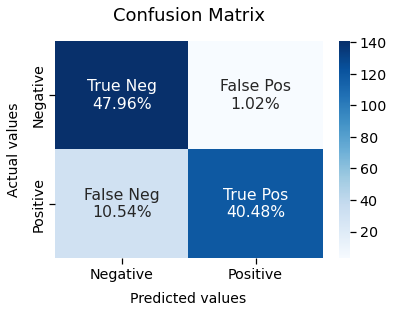

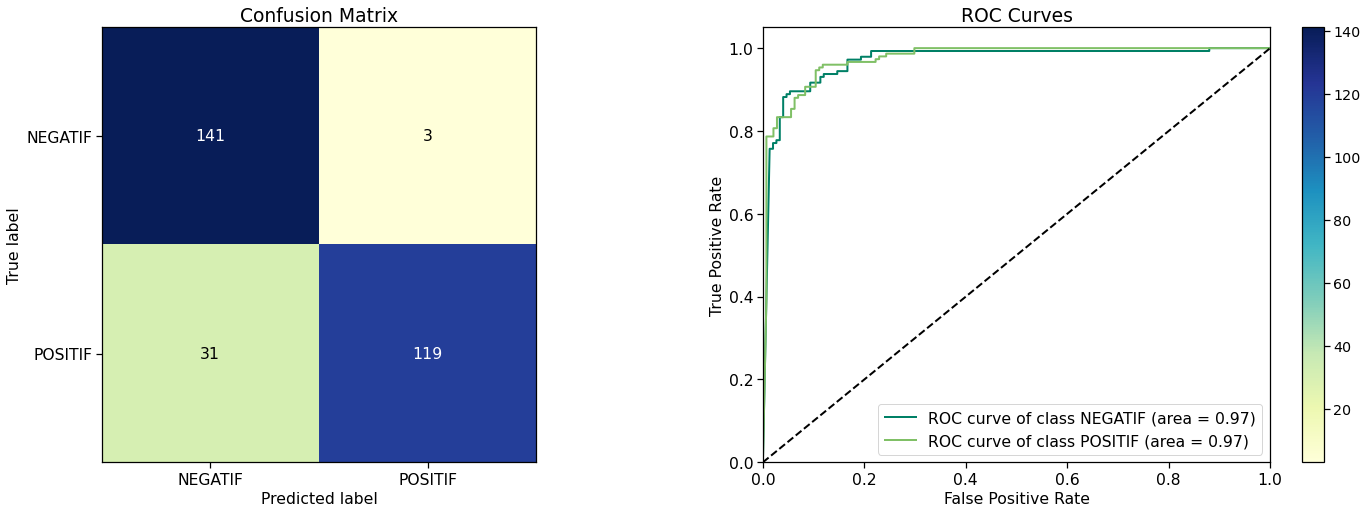

In [134]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

# SVM

[LibSVM]              precision    recall  f1-score   support

     NEGATIF       0.97      0.97      0.97       144
     POSITIF       0.97      0.97      0.97       150

    accuracy                           0.97       294
   macro avg       0.97      0.97      0.97       294
weighted avg       0.97      0.97      0.97       294



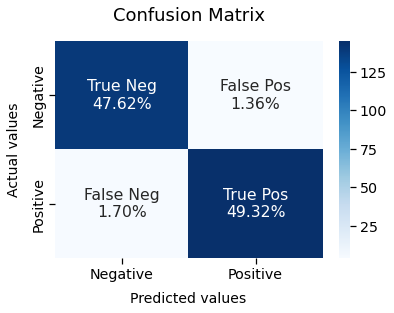

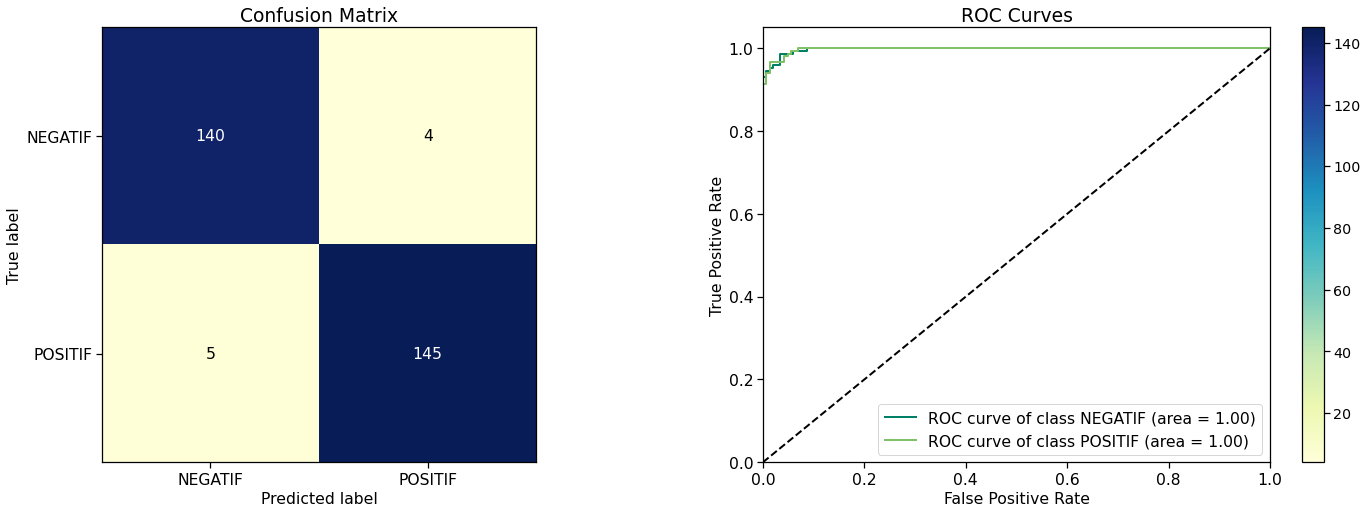

In [133]:
SVCmodel = SVC(kernel = 'rbf', probability=True, verbose=True)
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

# Logistic Regression

              precision    recall  f1-score   support

     NEGATIF       0.96      0.95      0.95       144
     POSITIF       0.95      0.96      0.96       150

    accuracy                           0.96       294
   macro avg       0.96      0.96      0.96       294
weighted avg       0.96      0.96      0.96       294



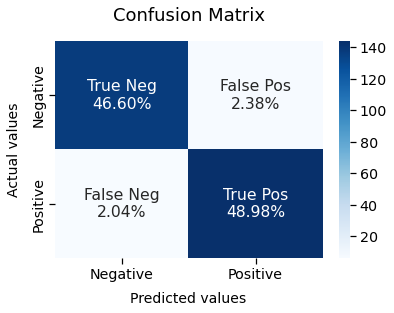

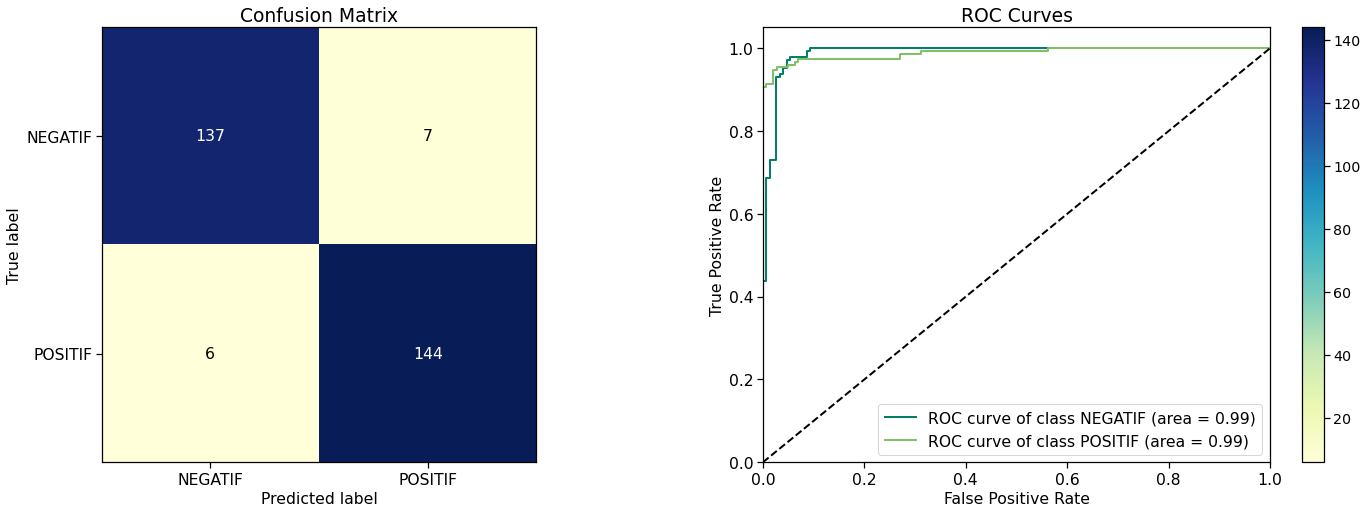

In [136]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

In [138]:


inputs = """Jenis bom yang digunakan oleh terduga pelaku Agus Sujatno alias Agus Muslim di Polsek Astanaanyar, Bandung, Jawa Barat, merupakan bom panci. Ledakan bom membuat sebagian bangunan di Polsek Astanaanyar rusak. Selain itu satu anggota polisi gugur dan beberapa alami luka-luka. "Terkait dengan bom yang digunakan oleh pelaku adalah jenis bom panci," kata Karo Penmas Divisi Humas Polri Brigjen Pol Ahmad Ramadhan di Polrestabes Bandung, Kamis (8/12/2022). "Daya ledaknya mengakibatkan sebagian bangunan kantor Polsek Astana Anyar mengalami kerusakan," jelasnya. Isi bom panci Dilansir dari Antara, Komandan Satbrimob Polda Jawa Barat Kombes Pol. Yuri Karsono menjelaskan, dari hasil olah TKP, bom panci yang dibawa pelaku berisi proyektil paku. Selain itu, ditemukan pula residu triaceton triperoxide (TATP) dan baterai yang diduga digunakan sebagai pemantik bom. "Jenis bom yang meledak adalah jenis bom rakitan, dirakit dalam bentuk panci, dan biasa rekan-rekan dengar dengan bom panci," kata Yuri dalam konferensi pers di Polrestabes Bandung, Kota Bandung Jawa Barat, Kamis. Sementara itu, soal daya ledak bom tersebut, Yuri mengaku masih melakukan pendalaman dengan Tim Penjinak Bom dan Pusat Laboratorium Forensik. Buru kelompok di balik teror bom Bandung Dilansir dari Antara, Kepala Badan Nasional Penanggulangan Terorisme (BNPT) Komjen Pol. Boy Rafli Amar di Bandung, menegaskan, pihaknya menyelidiki kelompok-kelompok yang diduga memberi bantuan terhadap aksi AS. Saat ini BNPT tengah berkoordinasi dengan pihak-pihak tertentu untuk mengungkap jaringan AS. "Kami masih ingin terus mencoba melihat kelompok lain yang memberikan perbantuan, kami terus menyelidiki ke arah itu," kata Boy saat meninjau Polsek Astanaanyar, Kota Bandung, Jawa Barat, Kamis."""
# tfidf.fit(inputs)
X_test = tfidf.transform([inputs])

all_sen = (LRmodel.predict(X_test)[0], SVCmodel.predict(X_test)[0], BNBmodel.predict(X_test)[0])
print(all_sen)

import statistics
from statistics import mode
 
def most_common(List):
    return(mode(List))

print(most_common(all_sen))

('POSITIF', 'POSITIF', 'NEGATIF')
POSITIF


In [115]:
SVCmodel.fit(x, y)
LRmodel.fit(x, y)
BNBmodel.fit(x, y)

[LibSVM]

BernoulliNB(alpha=2)

In [116]:
import pickle
pickle.dump(LRmodel, open('LRmodel.pkl','wb'))
pickle.dump(SVCmodel, open('SVCmodel.pkl','wb'))
pickle.dump(BNBmodel, open('BNBmodel.pkl','wb'))
pickle.dump(tfidf, open('tfidf.pkl', 'wb'))

In [117]:

LRmodel2 = pickle.load(open('C:/Users/nalia-pc/Dropbox/PC/Documents/===KULIAH===/Kuliah Semester 5/NLP/Ujian/UAS/KomSight/models/LRmodel.pkl','rb'))


In [118]:
LRmodel2 = pickle.load(open('C:/Users/nalia-pc/Dropbox/PC/Documents/===KULIAH===/Kuliah Semester 5/NLP/Ujian/UAS/KomSight/models/LRmodel.pkl','rb'))
SVCmodel2 = pickle.load(open('C:/Users/nalia-pc/Dropbox/PC/Documents/===KULIAH===/Kuliah Semester 5/NLP/Ujian/UAS/KomSight/models/SVCmodel.pkl','rb'))
BNBmodel2 = pickle.load(open('C:/Users/nalia-pc/Dropbox/PC/Documents/===KULIAH===/Kuliah Semester 5/NLP/Ujian/UAS/KomSight/models/BNBmodel.pkl','rb'))

inputs = """KOMPAS.com - Indonesia patut bangga karena memiliki banyak generasi muda yang terus mengembangkan minat, bakat serta kompetensinya di berbagai bidang dan meraih banyak prestasi. Kali ini, prestasi kembali diraih oleh dua siswa Indonesia, Btari Padma Zamzami dan Audrey Primadevi Subiakto, yang merupakan murid SMP Cikal Amri Setu. Btari dan Audrey berhasil meraih 13 medali, 6 Medali Emas dan 5 Medali Perak di Final Turnamen Akademik Pelajar Kelas Dunia, World Scholar’s Cup (WSC) Tournament of Champions (TOC) yang diikuti lebih dari 45 Negara dan lebih dari 1600 pelajar SMP/SMA seluruh dunia di Yale University, USA pada 13-18 November 2022. Baca juga: 6 Tanda Anak Cerdas Secara Emosional dan Cara Mengoptimalkannya World Scholar’s Cup sendiri merupakan turnamen akademik pelajar dunia yang paling terkenal dan digelar setiap tahunnya. Para pelajar yang hadir dan sampai ke tahap akhir merupakan para pelajar terbaik pilihan setiap negara. Perjalanan Aubrey dan Btari melangkah sampai tahap akhir dan meraih medali World Scholar’s Cup Tournament of Champions merupakan sebuah proses yang penuh dengan cerita. Keduanya berhasil sampai di titik tersebut setelah melalui Regional Round di Jakarta, dan Global Round di Vietnam. Audrey menuturkan bahwa bahwa persiapan untuk Tournament of Champions 2022 penuh dengan tantangan dan rasa gugup, namun dengan persiapan yang dilakukan dan juga semangat yang tak berhenti, Audrey merasa lega dan bangga bisa meraih medali untuk Indonesia. Baca juga: Terkenal Disiplin, Begini Cara Orangtua Jepang Mendidik Anak “Perasaanku selama Tournament of Champions itu nervous, apalagi karena TOC itu memang lebih susah daripada globals. tapi, pas event-nya udah mulai, perasaannya memang lebih enakan. untuk cara aku tetap semangat, aku banyak melakukan sosialisasi dengan Btari, Reaksa (teammate ketiga kita), dan teman-teman negara lainnya di TOC 2022,” ucapnya dalam keterangan resmi Sekolah Cikal. Audrey merasa bersyukur dapat membanggakan Indonesia dengan meraih medali emas dan perak."""
tfidf = TfidfVectorizer(ngram_range=(1,1))
tfidf.fit_transform([inputs])
X_test = tfidf.transform([inputs])

all_sen = (LRmodel2.predict(X_test)[0], SVCmodel2.predict(X_test)[0], BNBmodel2.predict(X_test)[0])
print(all_sen)
 
def most_common(List):
    return(mode(List))

print(most_common(all_sen))

ValueError: X has 172 features, but LogisticRegression is expecting 21785 features as input.